# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for one of its very expensive machines.  The very expensive machine has three operating modes: *normal*, *faulty* and *failed*.  The machine runs all the time, and usually it is in normal mode.  However, in the event that the machine enters faulty mode, the company would like to know as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for their very expensive machine.  When the machine is operating in normal mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before the very expensive machine fails it will enter a fault mode, during which the data appears visibilty quite different.  Finally, when a machine fails it enters a third distinctly different mode.

You can download the data here: [exampleco_data.csv](https://drive.google.com/file/d/1TiTIlGKSZ7LBlByYj9bXZ7LBZloV-P0H/view?usp=sharing)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like, or even other programming
   languages. Your final results should be presented in this notebook, however.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

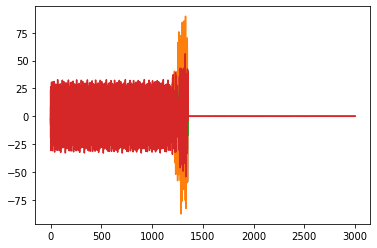

In [36]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

data = pd.read_csv('exampleco_data.csv',index_col=0)

plt.plot(range(len(data)), data)
plt.show()